<a href="https://colab.research.google.com/github/AdamVinestock/NLP-Final-Project/blob/main/Context_policy_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting repo and libraries

In [1]:
!git clone https://github.com/AdamVinestock/NLP-Final-Project

Cloning into 'NLP-Final-Project'...
remote: Enumerating objects: 850, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 850 (delta 147), reused 162 (delta 92), pack-reused 619
Receiving objects: 100% (850/850), 10.57 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (552/552), done.


In [2]:
!pip install --q transformers
!pip install datasets
!pip install sentencepiece
!python -m spacy download en_core_web_sm
!pip install spacy
!pip install multiple-hypothesis-testing
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.4 MB/s eta 0:00:00
2023-08-17 07:07:43.214418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with

In [3]:
# general
import os
import sys
import random
import warnings
from typing import List,Tuple
warnings.filterwarnings('ignore', '.*You seem to be using the pipelines sequentially on GPU.*')

# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForCausalLM

# Others
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from multitest import MultiTest

#sys.path.append('/content/NLP-Final-Project')


In [4]:
os.getcwd()
os.listdir('/content')
os.chdir('/content/NLP-Final-Project')

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#Downloading GPT2

In [6]:
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = AutoModelForCausalLM.from_pretrained("gpt2")
# model.to(DEVICE)
# model_name="gpt2"

tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
model = AutoModelForCausalLM.from_pretrained("gpt2-xl")
model.to(DEVICE)

# Calculating log-ppx

In [6]:
# If a push to the repo is performed, this will update the loaded repository
%cd /content/NLP-Final-Project
!git pull
import importlib

import src.ProcessResponses
importlib.reload(src.ProcessResponses)
from src.ProcessResponses import ResponseClass

import src.analyze_responses
importlib.reload(src.analyze_responses)
from src.analyze_responses import *

/content
Already up to date.


You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [7]:
fixed_context = "The following text was generated by a Large Language Model:"
context_policies = [None, 'previous-sentence', 'previous-3-sentences', None, 'summary-and-previous-sentence', 'QA']
fixed_context_list = [None, None, None, fixed_context, fixed_context, None]
policy_names = ['no-context', 'previous-sen', 'prev-3', 'naive', 'summary-and-prev', 'QA']

In [ ]:
# All response csv's were saved and uploaded to the repository at directory "Responses/"
# There is no need to run these lines

# wiki_intro_long_responses = ResponseClass("wiki-intro-long", model, model_name, tokenizer, context_policies, fixed_context_list, policy_names, from_sample=0, to_sample=1500)
# news_chatgpt_long_responses = ResponseClass("news-chatgpt-long", model, model_name, tokenizer, context_policies, fixed_context_list, policy_names, from_sample=0, to_sample=1500)
# ChatGPT_Research_Abstracts_responses = ResponseClass("ChatGPT-Research-Abstracts", model, model_name, tokenizer, context_policies, fixed_context_list, policy_names, from_sample=0, to_sample=1500)

# Processing Results

In [7]:
# Paths to csv's holding response values and sentence lengths
wiki_paths = [("Responses/wiki-intro-long_human_gpt2-xl_no-context_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_no-context_[0, 1500].csv"),
              ("Responses/wiki-intro-long_human_gpt2-xl_previous-sen_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_previous-sen_[0, 1500].csv"),
              ("Responses/wiki-intro-long_human_gpt2-xl_prev-3_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_prev-3_[0, 1500].csv"),
              ("Responses/wiki-intro-long_human_gpt2-xl_naive_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_naive_[0, 1500].csv"),
              ("Responses/wiki-intro-long_human_gpt2-xl_summary-and-prev_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_summary-and-prev_[0, 1500].csv"),
              ("Responses/wiki-intro-long_human_gpt2-xl_QA_[0, 1500].csv", "Responses/wiki-intro-long_machine_gpt2-xl_QA_[0, 1500].csv")]
news_paths = [("Responses/news-chatgpt-long_human_gpt2-xl_no-context_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_no-context_[0, 1500].csv"),
              ("Responses/news-chatgpt-long_human_gpt2-xl_previous-sen_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_previous-sen_[0, 1500].csv"),
              ("Responses/news-chatgpt-long_human_gpt2-xl_prev-3_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_prev-3_[0, 1500].csv"),
              ("Responses/news-chatgpt-long_human_gpt2-xl_naive_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_naive_[0, 1500].csv"),
              ("Responses/news-chatgpt-long_human_gpt2-xl_summary-and-prev_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_summary-and-prev_[0, 1500].csv"),
              ("Responses/news-chatgpt-long_human_gpt2-xl_QA_[0, 1500].csv", "Responses/news-chatgpt-long_machine_gpt2-xl_QA_[0, 1500].csv")]
research_paths = [("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_no-context_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_no-context_[0, 1500].csv"),
              ("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_previous-sen_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_previous-sen_[0, 1500].csv"),
              ("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_prev-3_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_prev-3_[0, 1500].csv"),
              ("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_naive_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_naive_[0, 1500].csv"),
              ("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_summary-and-prev_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_summary-and-prev_[0, 1500].csv"),
              ("Responses/ChatGPT-Research-Abstracts_human_gpt2-xl_QA_[0, 1500].csv", "Responses/ChatGPT-Research-Abstracts_machine_gpt2-xl_QA_[0, 1500].csv")]

In [8]:
# Preparing results into tables for examination
wiki_no_context = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[0][0], wiki_paths[0][1])
wiki_prev_sen = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[1][0], wiki_paths[1][1])
wiki_prev3 = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[2][0], wiki_paths[2][1])
wiki_naive = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[3][0], wiki_paths[3][1])
wiki_sumandprev = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[4][0], wiki_paths[4][1])
wiki_QA = prepare_results(wiki_paths[0][0], wiki_paths[0][1], wiki_paths[5][0], wiki_paths[5][1])

wiki_results = {
    'No Context - Baseline': wiki_no_context,
    'Previous Sentence': wiki_prev_sen,
    'Previous 3 Sentences': wiki_prev3,
    'Naive': wiki_naive,
    'Summary and Previous': wiki_sumandprev,
    'QA': wiki_QA}

df_wiki_results = pd.DataFrame.from_dict(wiki_results, orient='index', columns=[
    'Human mean response',
    'Machine mean response',
    'Human-Machine difference',
    'Diff from baseline',
    'AUC'])

news_no_context = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[0][0], news_paths[0][1])
news_prev_sen = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[1][0], news_paths[1][1])
news_prev3 = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[2][0], news_paths[2][1])
news_naive = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[3][0], news_paths[3][1])
news_sumandprev = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[4][0], news_paths[4][1])
news_QA = prepare_results(news_paths[0][0], news_paths[0][1], news_paths[5][0], news_paths[5][1])

news_results = {
    'No Context - Baseline': news_no_context,
    'Previous Sentence': news_prev_sen,
    'Previous 3 Sentences': news_prev3,
    'Naive': news_naive,
    'Summary and Previous': news_sumandprev,
    'QA': news_QA}

df_news_results = pd.DataFrame.from_dict(news_results, orient='index', columns=[
    'Human mean response',
    'Machine mean response',
    'Human-Machine difference',
    'Diff from baseline',
    'AUC'])

research_no_context = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[0][0], research_paths[0][1])
research_prev_sen = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[1][0], research_paths[1][1])
research_prev3 = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[2][0], research_paths[2][1])
research_naive = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[3][0], research_paths[3][1])
research_sumandprev = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[4][0], research_paths[4][1])
research_QA = prepare_results(research_paths[0][0], research_paths[0][1], research_paths[5][0], research_paths[5][1])

research_results = {
    'No Context - Baseline': research_no_context,
    'Previous Sentence': research_prev_sen,
    'Previous 3 Sentences': research_prev3,
    'Naive': research_naive,
    'Summary and Previous': research_sumandprev,
    'QA': research_QA}

df_research_results = pd.DataFrame.from_dict(research_results, orient='index', columns=[
    'Human mean response',
    'Machine mean response',
    'Human-Machine difference',
    'Diff from baseline',
    'AUC'])

In [9]:
# Note that the difference between histograms is normalised by the pooled std: (human_mean - machine_mean)/pooled_std
print(tabulate(df_wiki_results, headers='keys', tablefmt='psql'))
print("\nNews-chatgpt-long Dataset")
print(tabulate(df_news_results, headers='keys', tablefmt='psql'))
print("\nChatGPT-Research-Abstracts Dataset")
print(tabulate(df_research_results, headers='keys', tablefmt='psql'))

+-----------------------+-----------------------+-------------------------+----------------------------+--------------------------+----------+
|                       |   Human mean response |   Machine mean response |   Human-Machine difference | Diff from baseline       |      AUC |
|-----------------------+-----------------------+-------------------------+----------------------------+--------------------------+----------|
| No Context - Baseline |               3.58052 |                 2.9372  |                   0.730682 | 0                        | 0.725778 |
| Previous Sentence     |               3.26394 |                 2.37983 |                   0.926891 | + 0.19620936536634925 ↑  | 0.796196 |
| Previous 3 Sentences  |               3.04945 |                 2.0539  |                   1.09394  | + 0.3632603987907569 ↑   | 0.837127 |
| Naive                 |               4.17584 |                 3.4623  |                   0.667109 | - 0.0635728448194951 ↓   | 0.719042 |

Best performing context policy comparison for wiki dataset


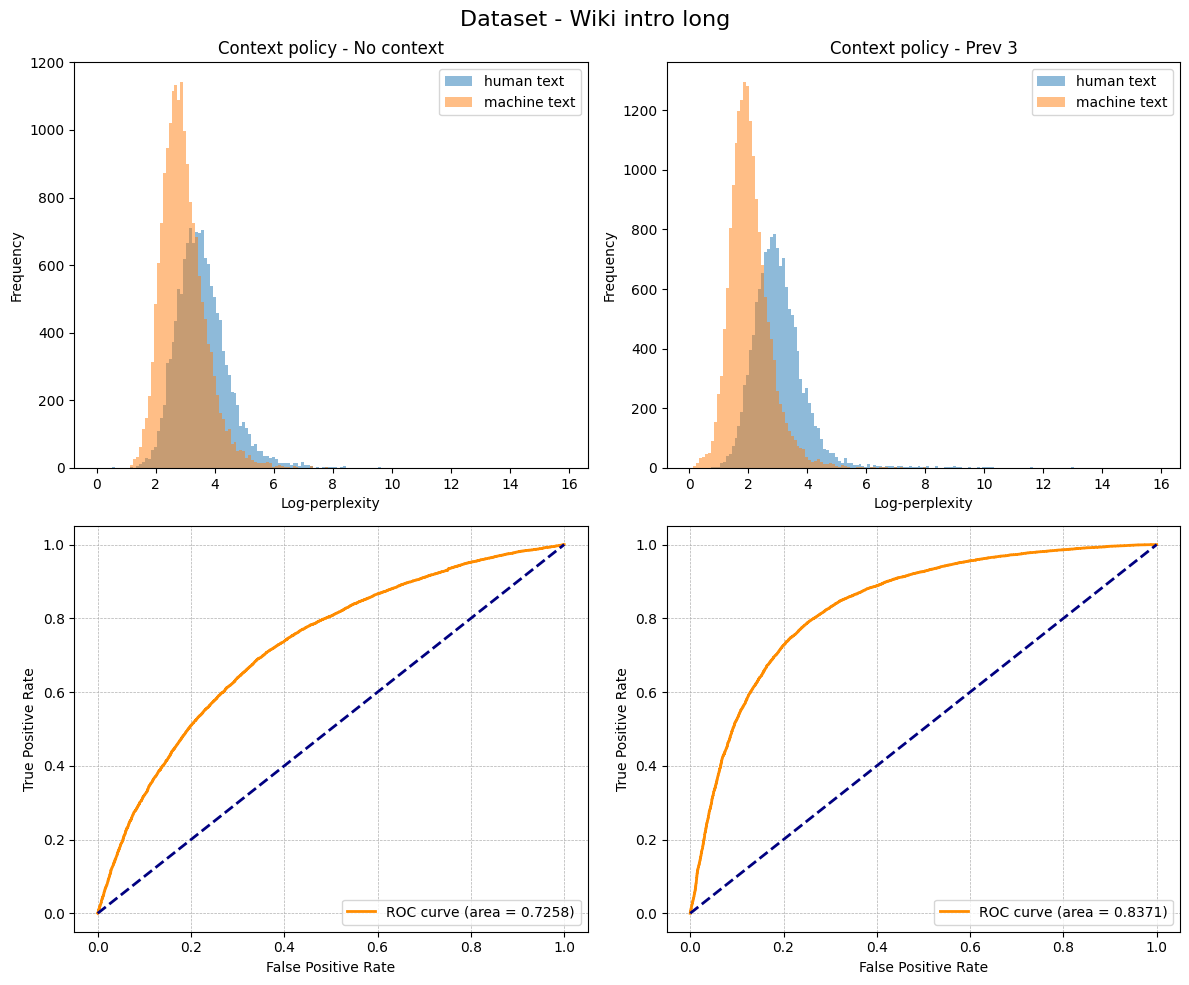

In [14]:
# Note ROC and AUC values consider the following:
  # TP are all human responses with perplexity value above threshold
  # FP are all machine responses with perplexity value above threshold
  # TN are all machine responses with perplexity value below threshold
  # FN are all human responses with perplexity value below threshold
print("Best performing context policy comparison for wiki dataset")
compare_hist(wiki_paths[0][0], wiki_paths[0][1],
             wiki_paths[2][0], wiki_paths[2][1])

Best performing context policy comparison for news dataset


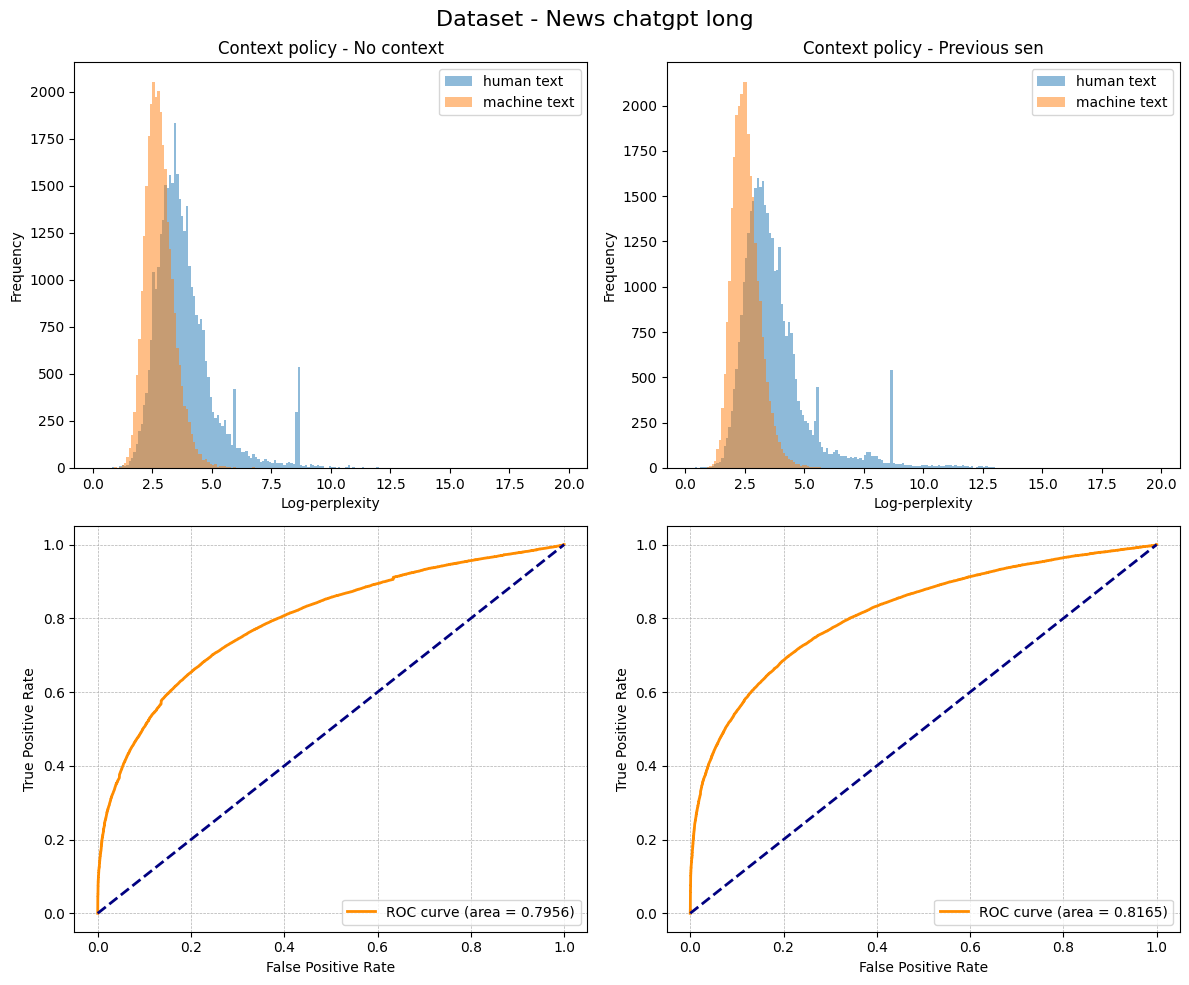

In [17]:
print("Best performing context policy comparison for news dataset")
compare_hist(news_paths[0][0], news_paths[0][1],
             news_paths[1][0], news_paths[1][1])

Best performing context policy comparison for research abstract dataset


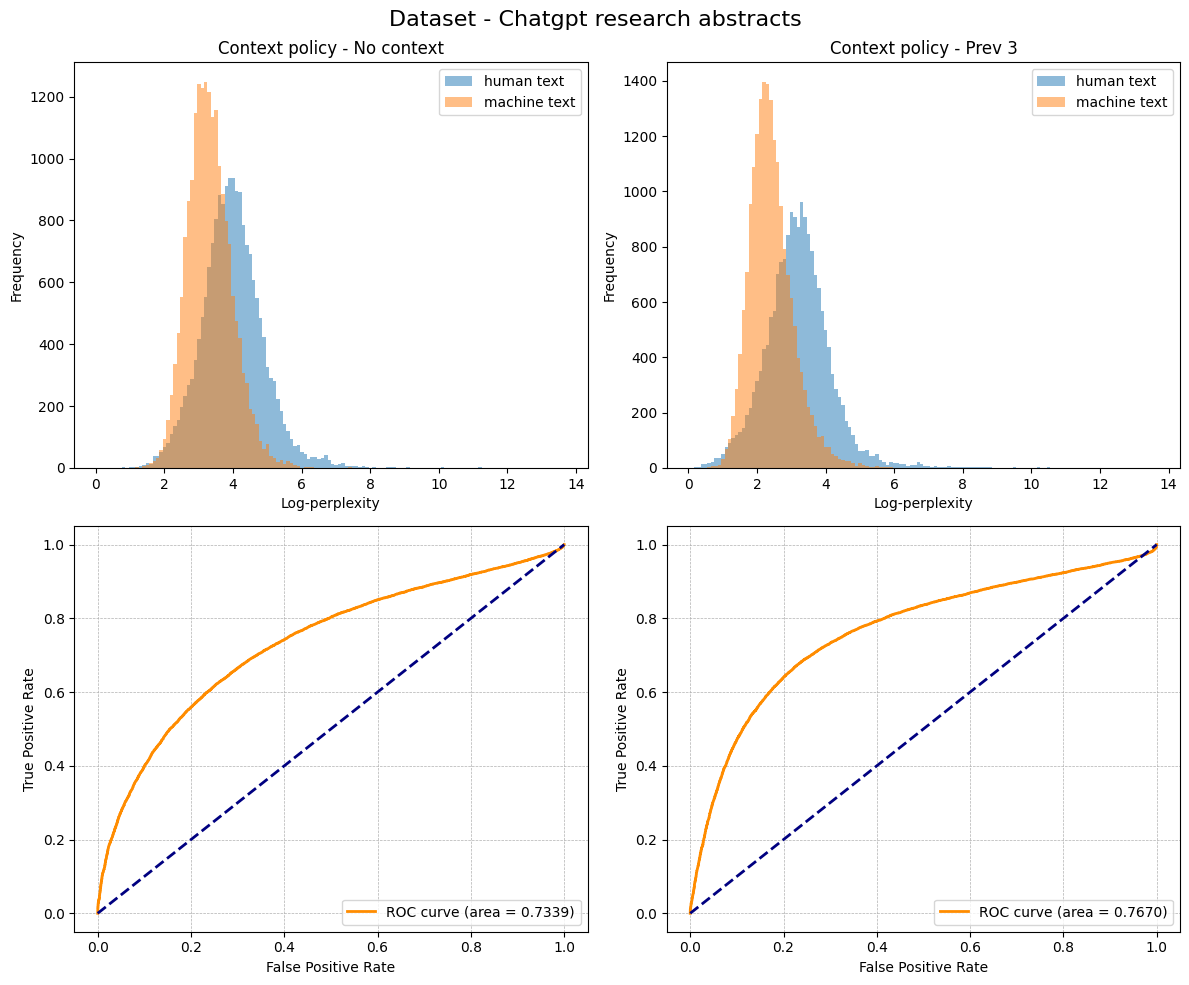

In [16]:
print("Best performing context policy comparison for research abstract dataset")
compare_hist(research_paths[0][0], research_paths[0][1],
             research_paths[2][0], research_paths[2][1])

Comparing previous sentence to summary and previous in wiki dataset


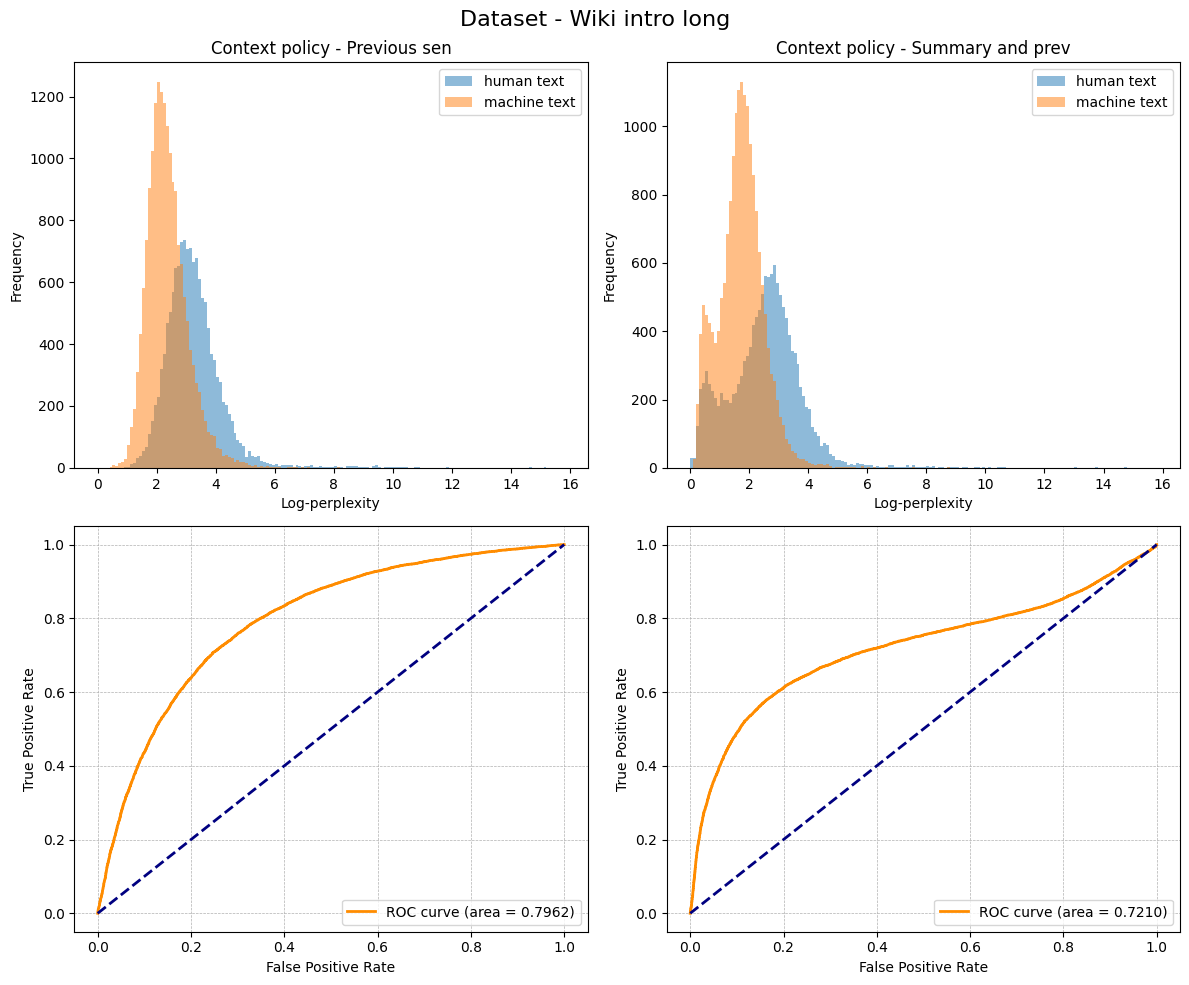

In [10]:
print("Comparing previous sentence to summary and previous in wiki dataset")
compare_hist(wiki_paths[1][0], wiki_paths[1][1],
             wiki_paths[4][0], wiki_paths[4][1])

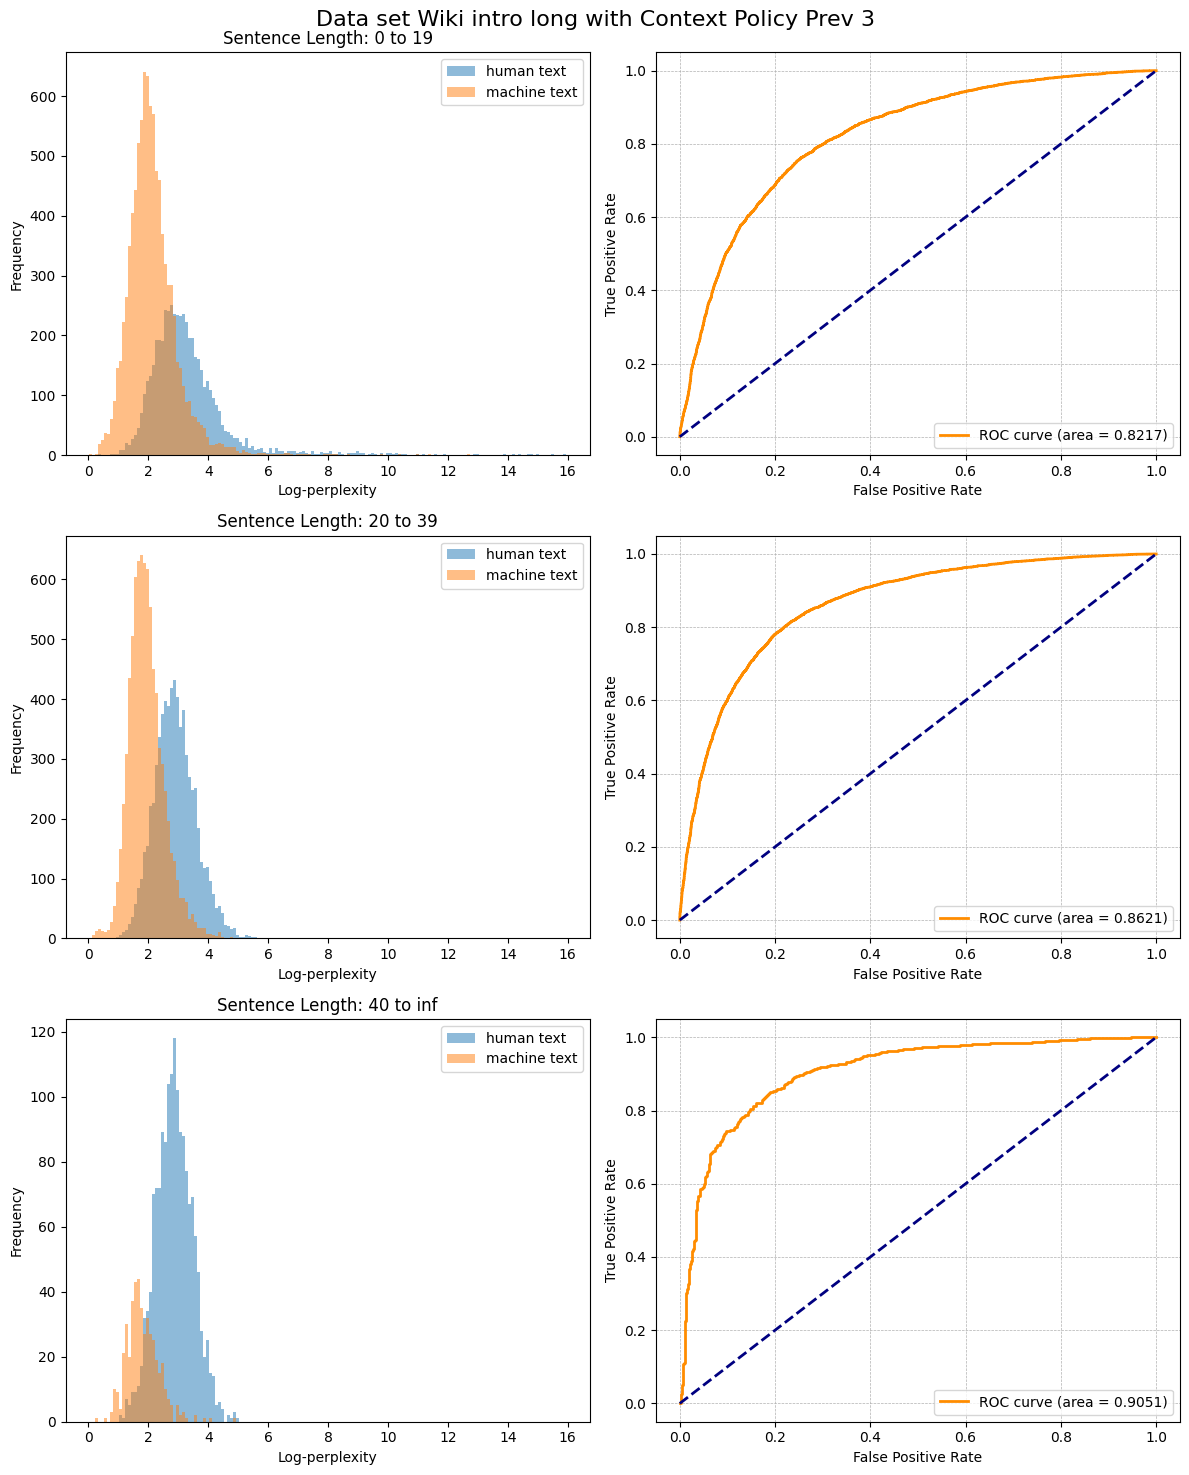

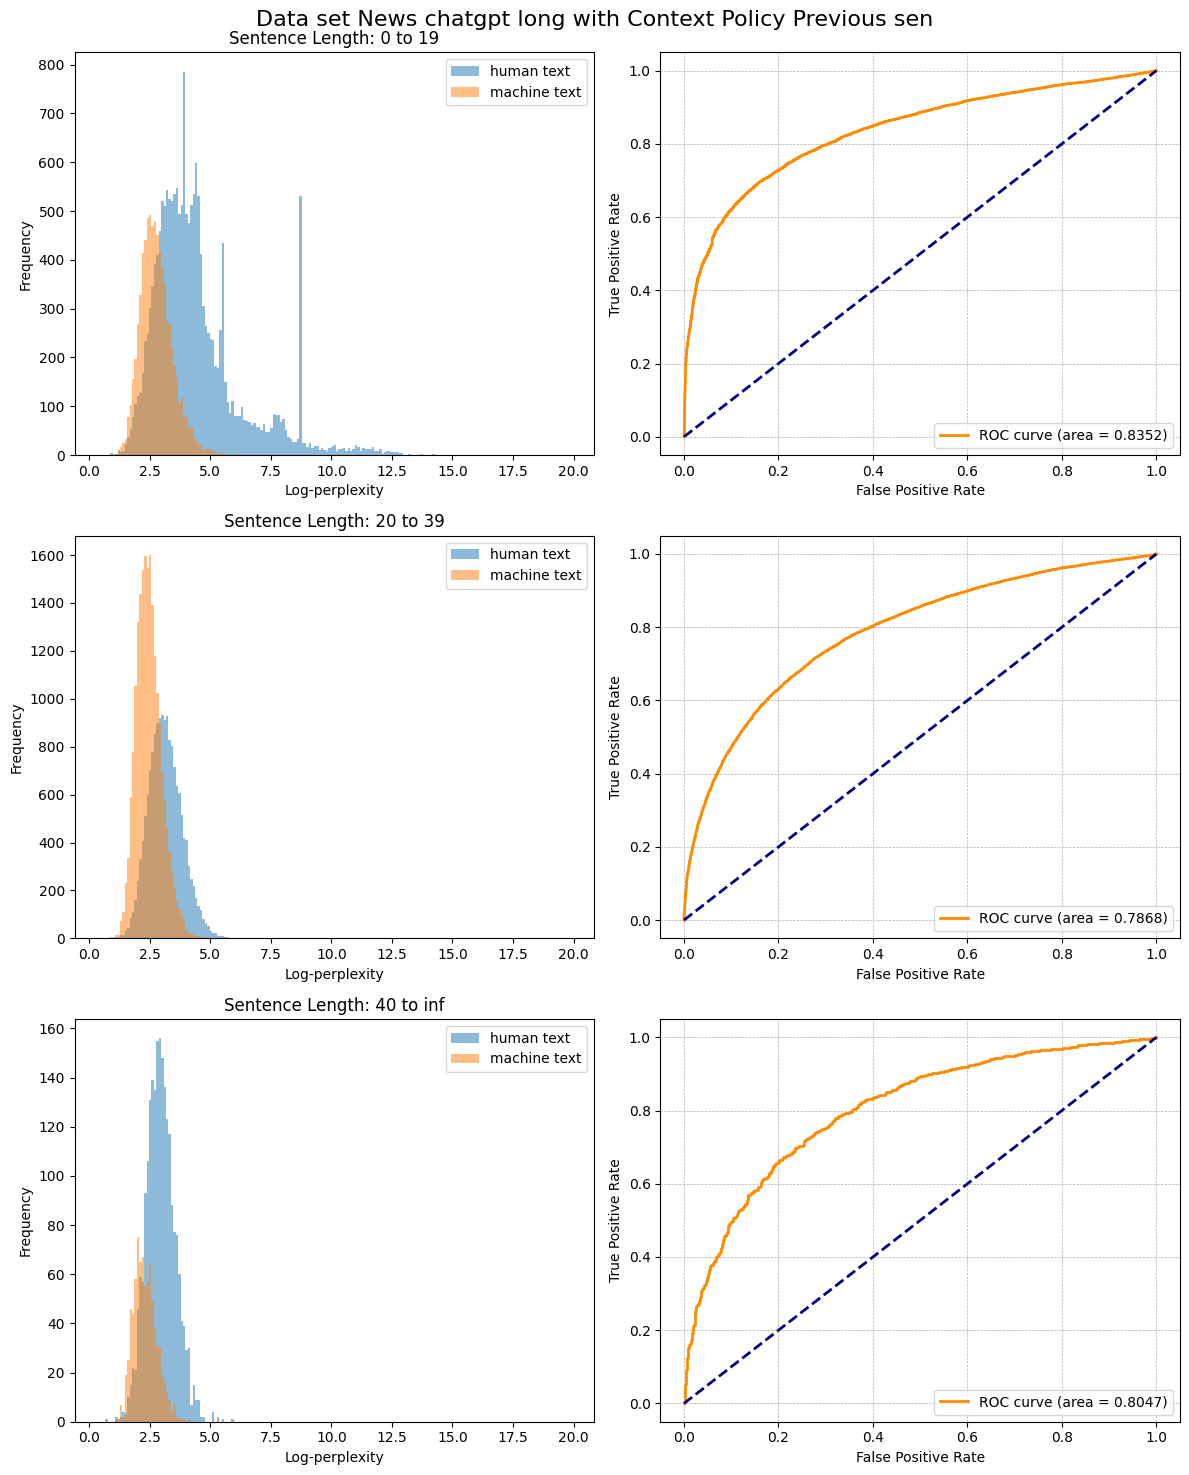

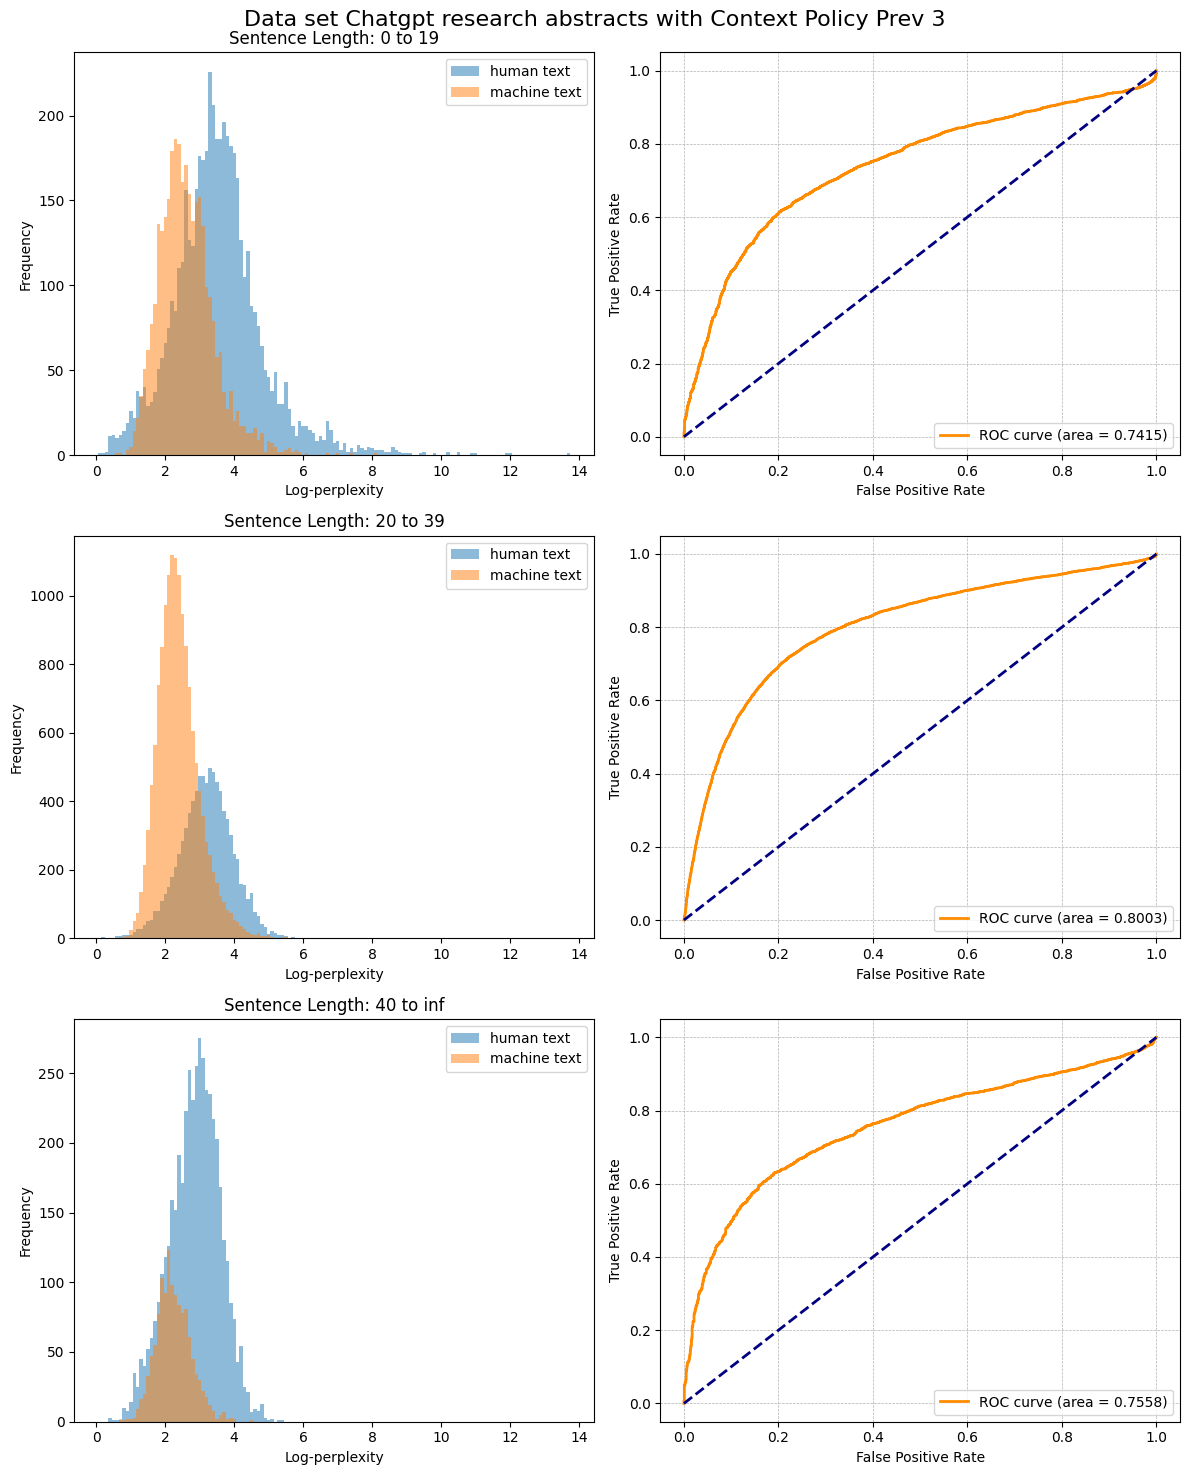

In [20]:
# Comparing best performing context policy over different sentence lengths
sen_length_separation(wiki_paths[2][0], wiki_paths[2][1])
sen_length_separation(news_paths[1][0], news_paths[1][1])
sen_length_separation(research_paths[2][0], research_paths[2][1])

Comparison of context policy across all 3 domains


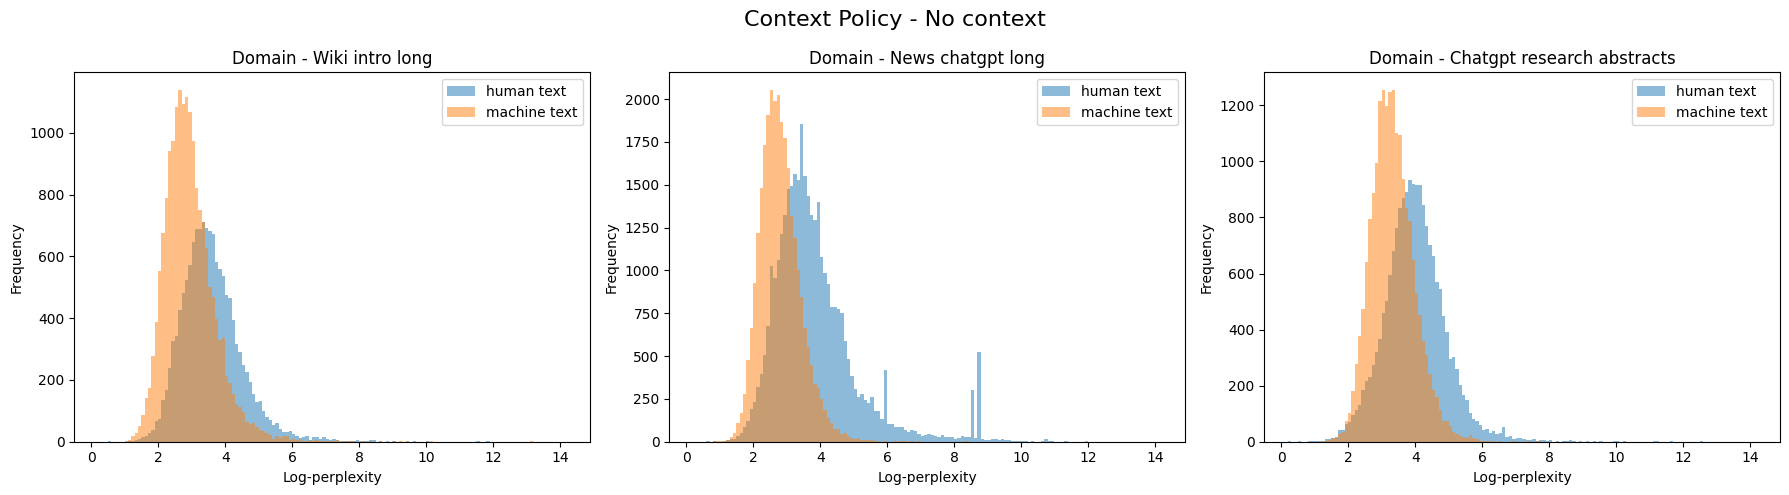

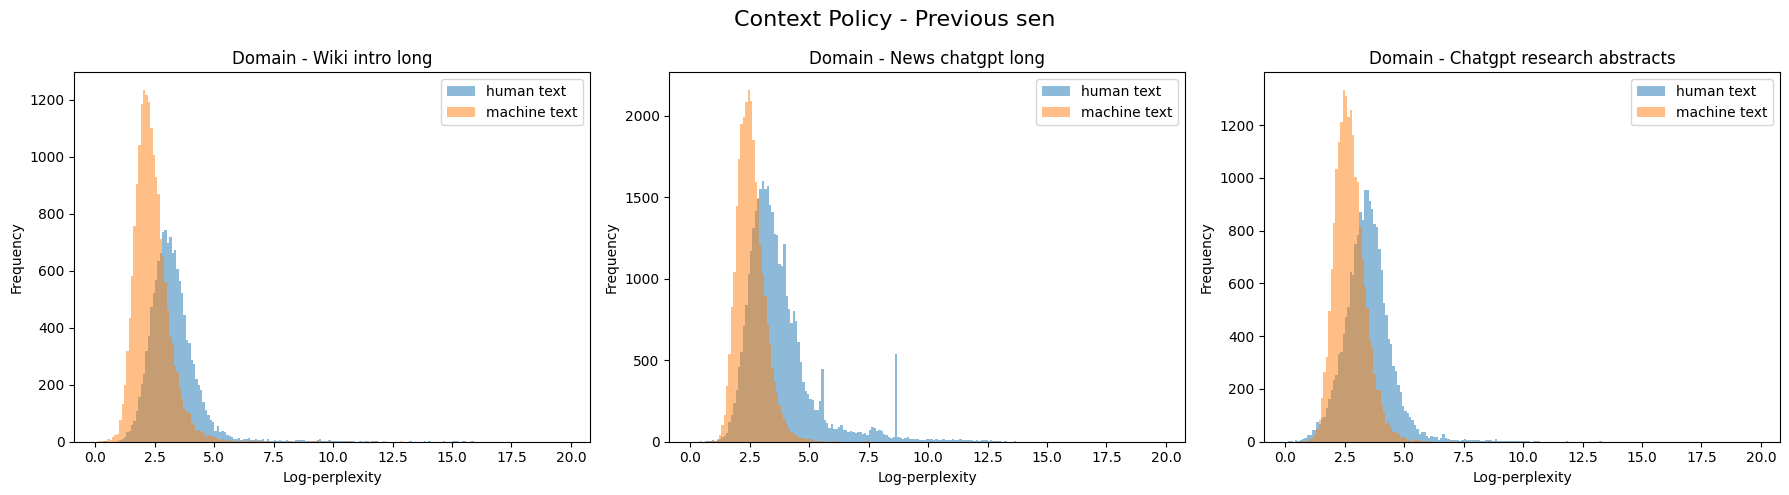

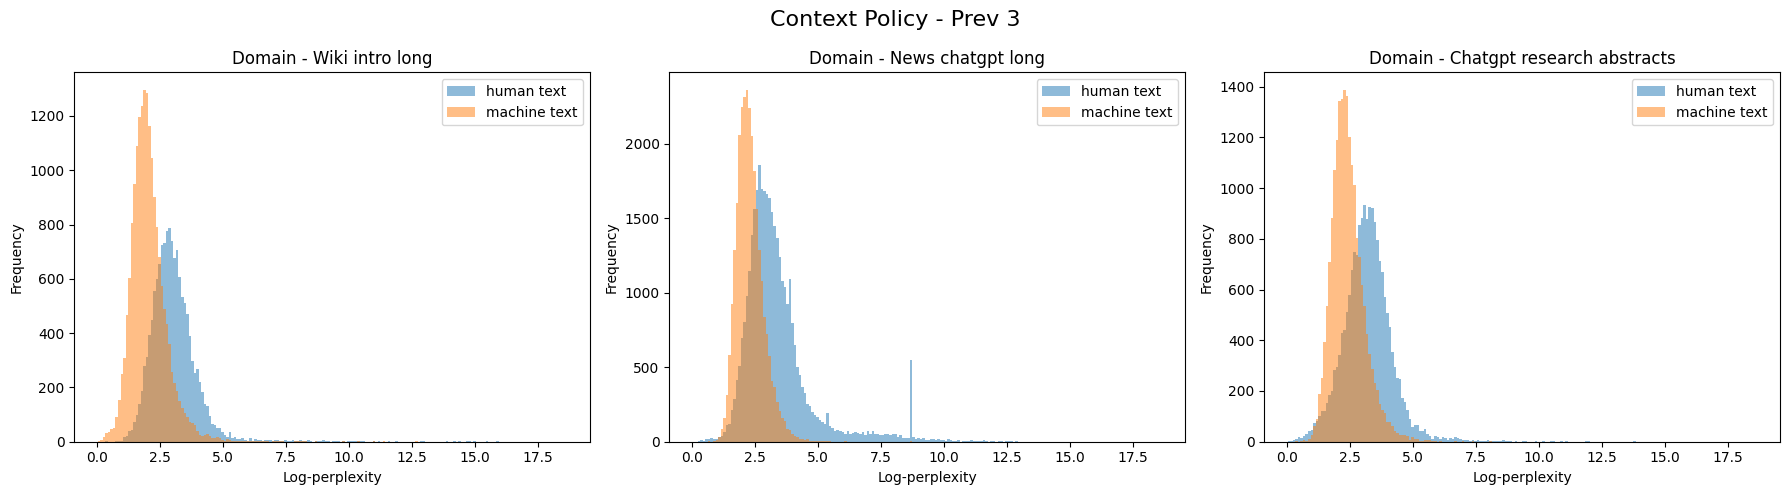

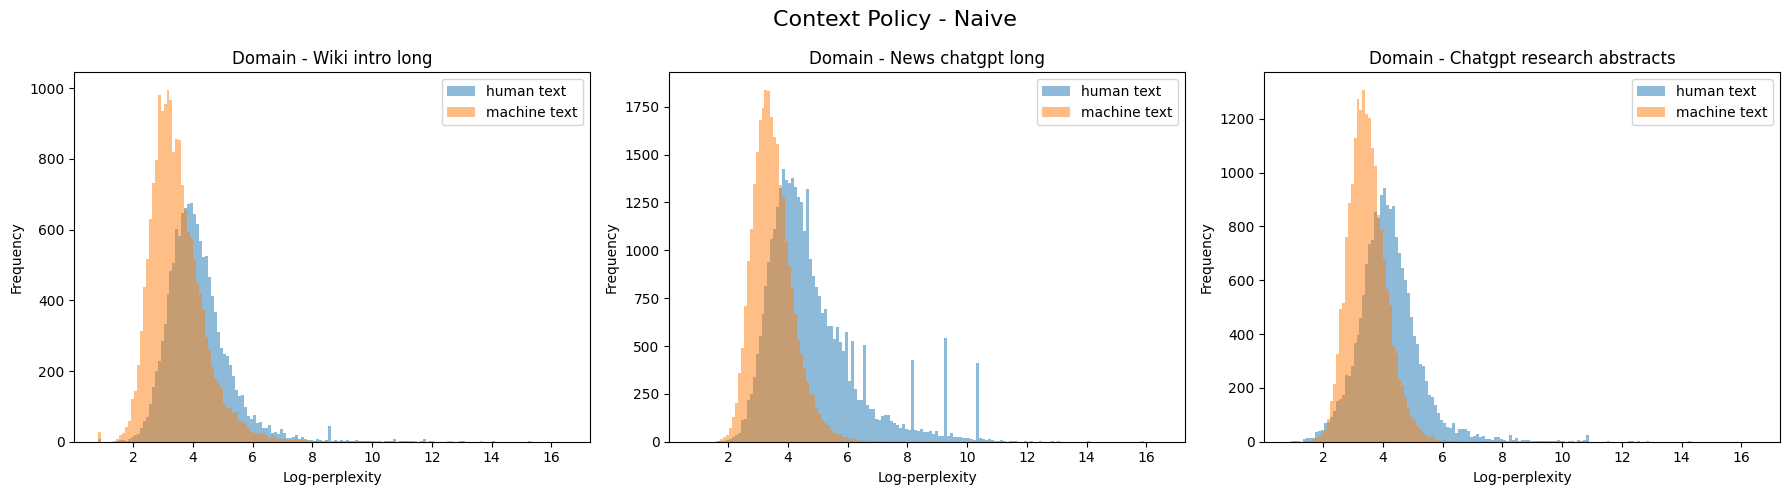

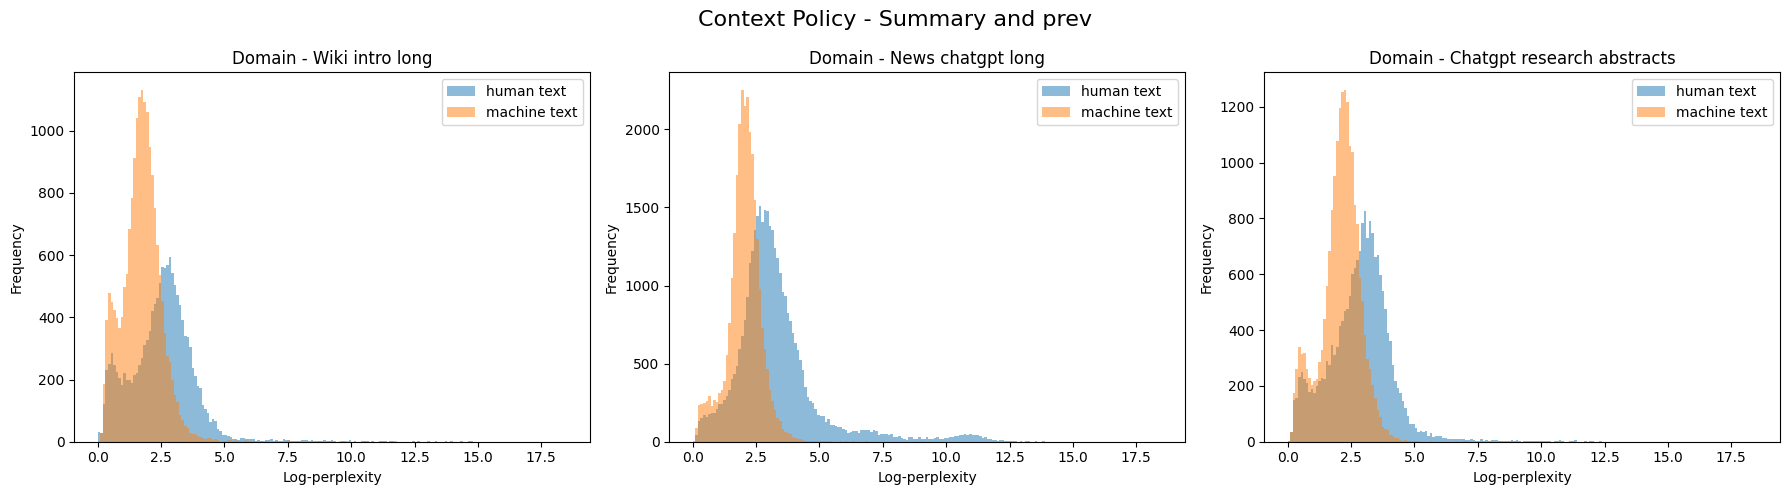

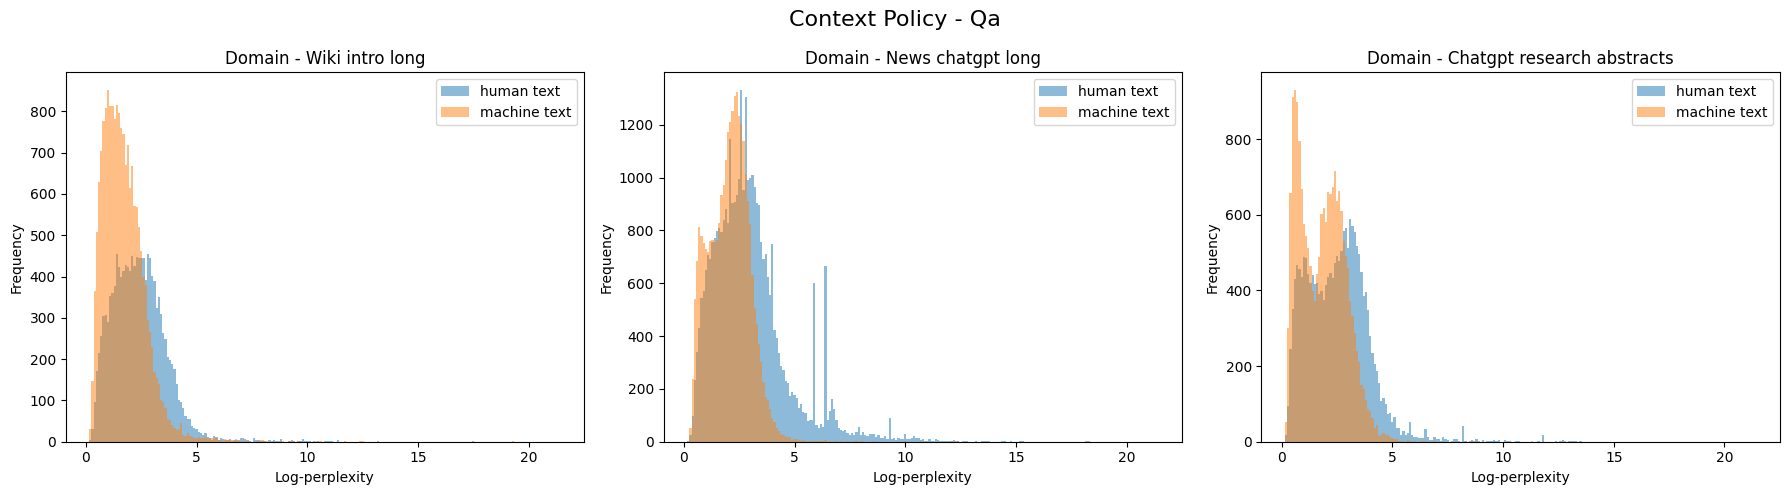

In [34]:
print("Comparison of context policy across all 3 domains")
compare_context_domain(wiki_paths[0][0], wiki_paths[0][1], news_paths[0][0], news_paths[0][1], research_paths[0][0], research_paths[0][1])
compare_context_domain(wiki_paths[1][0], wiki_paths[1][1], news_paths[1][0], news_paths[1][1], research_paths[1][0], research_paths[1][1])
compare_context_domain(wiki_paths[2][0], wiki_paths[2][1], news_paths[2][0], news_paths[2][1], research_paths[2][0], research_paths[2][1])
compare_context_domain(wiki_paths[3][0], wiki_paths[3][1], news_paths[3][0], news_paths[3][1], research_paths[3][0], research_paths[3][1])
compare_context_domain(wiki_paths[4][0], wiki_paths[4][1], news_paths[4][0], news_paths[4][1], research_paths[4][0], research_paths[4][1])
compare_context_domain(wiki_paths[5][0], wiki_paths[5][1], news_paths[5][0], news_paths[5][1], research_paths[5][0], research_paths[5][1])

In [ ]:
from src.dataset_loaders import (get_text_from_wiki_long_dataset,
                                 get_text_from_chatgpt_news_long_dataset,
                                 get_text_from_chatgpt_abstracts_dataset)
from transformers import AutoTokenizer, AutoModelForCausalLM
from src.fit_survival_function import fit_per_length_survival_function
from src.DetectLM import DetectLM
from src.PerplexityEvaluator import PerplexityEvaluator
from src.PrepareSentenceContext import PrepareSentenceContext

human_dataset = get_text_from_chatgpt_news_long_dataset(shuffle=False, text_field='human_text')
h_df, m_df = pd.read_csv("Responses/wiki-intro-long_human_gpt2-xl_no-context_[0, 1500].csv"), pd.read_csv("Responses/wiki-intro-long_machine_gpt2-xl_no-context_[0, 1500].csv")

# Reading null data and fit p-value function for every sentence length
pval_func = fit_per_length_survival_function(m_df['length'], m_df['response'])

# Initialize PerplexityEvaluator with a language model and a tokenizer
lm_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(lm_name)

sentence_detector = PerplexityEvaluator(AutoModelForCausalLM.from_pretrained(lm_name),
                    AutoTokenizer.from_pretrained(lm_name))

# initialize the detector...
detector = DetectLM(sentence_detector, pval_func,
                    length_limit_policy='truncate')

# parse text from an input file
# with open(INPUT_FILE, 'rt') as f:
#     text = f.read()
parse_chunks = PrepareSentenceContext(context_policy='no-context')
text = human_dataset['text']
chunks = parse_chunks(text[0])

# Test document
res = detector(chunks['text'], chunks['context'])

In [ ]:
dataset_name = 'wiki-long'
model_name = "gpt2"
eps = 0.1
ds_merged = m_df.merge(h_df, on='name', how='inner')
joint_names = ds_merged['name'].tolist()

ds_pool = h_df[h_df['name'].isin(joint_names)]
ds_sample = ds_pool.groupby("name").sample(frac=eps)

print(len(ds_sample))

ds_sample['human'] = True
m_df['human'] = False
ds_mixed = pd.concat([m_df[m_df['name'].isin(joint_names)], ds_sample])

print(ds_mixed.groupby('name')['human'].mean().mean())

def group_articles_to_minimum_length(df, min_length):
    """
    Rearrange group names so that every group has at least
    :min_length: elements
    """
    df_grouped = df.copy()
    df_grouped.loc[:, 'new_name'] = df['name'].copy()
    groups = list(ds_mixed.groupby('name'))
    lo_names = []
    while len(groups) > 0:
        c = groups.pop(0)
        acc = len(c[1])
        while (acc <= min_length) and len(groups)>0:
            c1 = groups.pop(0)
            acc += len(c1[1])
            df_grouped.loc[df['name'] == c1[0], 'new_name'] = c[0]

    return df_grouped

min_length = 100
ds_mixed_grouped = group_articles_to_minimum_length(ds_mixed, min_length)

min_no_sentences = 10

results = []
too_short = []
for c in tqdm(ds_mixed_grouped.groupby('new_name')):
    responses = c[1]['response']
    lengths = c[1]['length']
    if len(responses) > min_no_sentences:
      pvals, comments = detector._get_pvals(responses, lengths)
      pvals = np.vstack(pvals).squeeze()
      mt = MultiTest(pvals, stbl=stbl)
      hc = mt.hc()[0]
      results.append(dict(id=c[0], HC=hc))
    else:
       too_short.append(c)

# Loading Llama2

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
%cd /content/NLP-Final-Project
!git pull

import many_atomic_detections
import importlib
importlib.reload(many_atomic_detections)
from many_atomic_detections import process_text, iterate_over_texts

import src.PerplexityEvaluator
importlib.reload(src.PerplexityEvaluator)
from src.PerplexityEvaluator import PerplexityEvaluator

import src.PrepareSentenceContext
importlib.reload(src.PrepareSentenceContext)
from src.PrepareSentenceContext import PrepareSentenceContext

import src.dataset_loaders
importlib.reload(src.dataset_loaders)
from src.dataset_loaders import get_text_from_wiki_long_dataset

import src.summarizer
importlib.reload(src.summarizer)

/content/NLP-Final-Project
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 358 bytes | 358.00 KiB/s, done.
From https://github.com/AdamVinestock/NLP-Final-Project
   298ccbb..9272dc8  main       -> origin/main
Updating 298ccbb..9272dc8
Fast-forward
 src/PrepareSentenceContext.py | 10 +++++-----
 1 file changed, 5 insertions(+), 5 deletions(-)


<module 'src.summarizer' from '/content/NLP-Final-Project/src/summarizer.py'>

In [ ]:
# Load model
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer_llama2 = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
model_llama2 = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf")
model_llama2 = model_llama2.half()
model_llama2.to(DEVICE)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [ ]:
sentence_detector = PerplexityEvaluator(model_llama2, tokenizer_llama2)
dataset = get_text_from_wiki_long_dataset(shuffle=False, text_field='generated_text')
truncated_dataset = dataset.select(range(30))

# Build parsers
parser_no_context = PrepareSentenceContext(context_policy= None, context=None)
parser_previous_sen = PrepareSentenceContext(context_policy='previous_sentence', context=None)
parser_naive = PrepareSentenceContext(context_policy=None, context="This sentence was generated by a Large Language Model:")
parser_naive_and_prev = PrepareSentenceContext(context_policy='previous_sentence', context="This sentence was generated by a Large Language Model:")
parser_summary = PrepareSentenceContext(context_policy='summary', context=None)
parser_summary_and_prev = PrepareSentenceContext(context_policy='summary_and_previous_sentence', context=None)
parser_prev_3 = PrepareSentenceContext(context_policy='previous_3_sentences', context=None)
parser_naive_and_prev_3 = PrepareSentenceContext(context_policy='previous_3_sentences', context="This text was generated by a Large Language Model:")

# Perform log ppx calculation
iterate_over_texts(truncated_dataset, sentence_detector, parser_no_context, "results_no_context.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_previous_sen, "results_previous_sen.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_naive, "results_naive.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_naive_and_prev, "results_naive_and_prev.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_summary, "results_summary.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_summary_and_prev, "results_summary_and_prev_sen.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_prev_3, "results_prev_3.csv")
iterate_over_texts(truncated_dataset, sentence_detector, parser_naive_and_prev_3, "results_naive_and_prev_3.csv")

100%|██████████| 30/30 [00:18<00:00,  1.64it/s]
